In [1]:
import logging
from pathlib import Path
import sys
import data_loading
import utils
import explainers
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings


In [2]:
logging.basicConfig(format='%(asctime)s %(levelname)-7s %(message)s',
                    stream=sys.stderr, level=logging.DEBUG)
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)

In [3]:
DATASET_NAME = 'cstr2'
WINDOW_SIZE = 10

In [4]:
# exclude_columns = ['Fault']

In [5]:
timeseries, labels, test_timeseries, test_labels = \
        data_loading.get_dataset(DATASET_NAME, binary=False, window_size=WINDOW_SIZE, noise_scale=0.01, use_classes=list(range(0,10)))

In [6]:
# print(timeseries)
# print(labels.head)
print(test_timeseries)
# print(labels['label'])

                          Caf         h          Qf        Ca           T  \
node_id   timestamp                                                         
node_1_10 1          1.008860  5.975931   99.478727  0.037249  406.943779   
          2          1.000599  5.962339  101.954637  0.037577  403.775644   
          3          0.994616  6.006192   99.221353  0.037281  402.210182   
          4          1.014378  6.152473  100.384223  0.037287  400.188665   
          5          1.013128  5.987800  101.340664  0.037024  398.589307   
...                       ...       ...         ...       ...         ...   
node_9_99 95         1.015116  5.897648   98.895032  0.053044  397.172822   
          96         0.993018  5.925843  102.439618  0.052640  401.326356   
          97         0.996720  5.956462   99.579218  0.053366  388.219332   
          98         0.999432  6.012015  100.133409  0.054194  399.559010   
          99         1.008477  5.976279   99.712033  0.052502  397.046070   

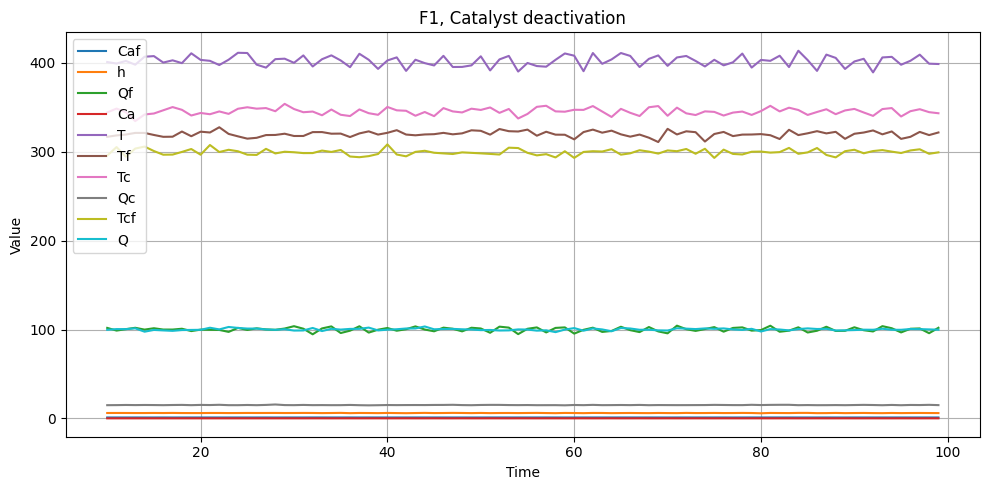

In [7]:
comparison_df=pd.DataFrame(test_timeseries)
comparison_df = comparison_df.groupby(level='node_id').last()
comparison_df['ind_node'] = ([int(element.split('_')[1]) for element in comparison_df.index.get_level_values('node_id')])
comparison_df['ind_time'] = ([int(element.split('_')[2]) for element in comparison_df.index.get_level_values('node_id')])
comparison_df.set_index(['ind_node', 'ind_time'], inplace=True)
label_dict = {'1': 'F1, Catalyst deactivation', '2': 'F2, Heat-exchanger fouling', '3': 'F3, Dead-coolant flow measurement', '4': 'F4, Bias in reactor temperature measurement', '5': 'F5, Coolant valve stiction qF7', '6': 'F6, Step change in QF', '7': 'F7, Ramp change in CAF', '8': 'F8, Ramp change in TF', '9': 'F9, Ramp change in TCF', '0': 'N, Normal operation'}

for i in range(1,2):
    single_node_df = comparison_df.loc[comparison_df.index.get_level_values('ind_node') == i]
    single_node_df = single_node_df.reset_index(level='ind_node', drop=True)
    single_node_df = single_node_df.sort_index()
    
    single_node_df_filtered = single_node_df

    # columns_to_plot = ['Ca']
    # single_node_df_filtered = single_node_df[columns_to_plot]    

    # scaler = MinMaxScaler()
    # single_node_df_filtered = pd.DataFrame(scaler.fit_transform(single_node_df_filtered), columns=single_node_df_filtered.columns, index=single_node_df_filtered.index)    
    
    # print(single_node_df_filtered)

    single_node_df_filtered.plot(figsize=(10, 5))
    
    plt.title(label_dict[str(i)])
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid(True)
    plt.legend(loc='upper left')
    # plt.ticklabel_format(style='sci', axis='y', scilimits=(100,200))
    # plt.yticks(np.arange(0, 500, step=10))
    # plt.xticks(np.arange(WINDOW_SIZE, len(single_node_df_filtered), step=1), rotation=45)
    # plt.xlim(single_node_df_filtered.index[5], single_node_df_filtered.index[45])
    plt.tight_layout()
    plt.show()


In [8]:
extractor = utils.TSFeatureGenerator(threads=1, trim=0)
pipeline = Pipeline([
    ('assert1', utils.CheckFeatures()),
    ('features', utils.TSFeatureGenerator(threads=1, trim=0)),
    ('assert2', utils.CheckFeatures()),
    ('scaler', MinMaxScaler(feature_range=(-1, 1))),
    ('clf', RandomForestClassifier(n_estimators=100))
], verbose=True)

In [9]:
pipeline.fit(timeseries, labels)

[Pipeline] ........... (step 1 of 5) Processing assert1, total=   0.0s
[Pipeline] .......... (step 2 of 5) Processing features, total=   4.2s
[Pipeline] ........... (step 3 of 5) Processing assert2, total=   0.0s
[Pipeline] ............ (step 4 of 5) Processing scaler, total=   0.0s


/Users/omkar/anaconda3/envs/comte1/lib/python3.9/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[Pipeline] ............... (step 5 of 5) Processing clf, total=   0.2s


Pipeline(steps=[('assert1', CheckFeatures()),
                ('features', TSFeatureGenerator(threads=1, trim=0)),
                ('assert2', CheckFeatures()),
                ('scaler', MinMaxScaler(feature_range=(-1, 1))),
                ('clf', RandomForestClassifier())],
         verbose=True)

In [10]:
preds = pipeline.predict(test_timeseries)

In [11]:
print("F1 score:", f1_score(test_labels, preds, average='weighted'))
for label, i in zip(np.unique(test_labels), f1_score(test_labels, preds, labels=np.unique(test_labels), average=None)):
    print(label, i)

F1 score: 0.8994941393114583
0 0.8865435356200527
1 1.0
2 0.8859060402684564
3 0.8181818181818182
4 0.8429752066115702
5 0.7454545454545455
6 0.9777777777777777
7 1.0
8 0.9927007299270073
9 0.8679245283018868


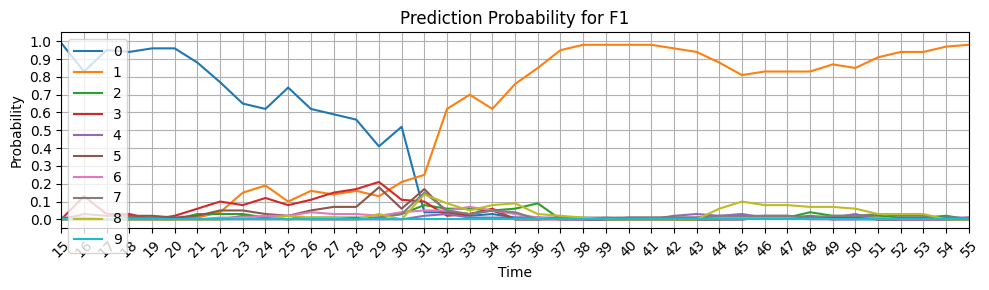

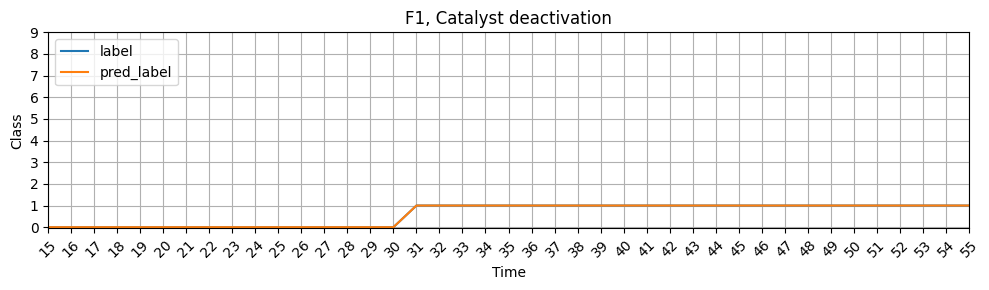

In [12]:
comparison_df=pd.DataFrame(test_labels)
comparison_df['pred_label'] = preds
comparison_df['ind_node'] = ([int(element.split('_')[1]) for element in comparison_df.index.get_level_values('node_id')])
comparison_df['ind_time'] = ([int(element.split('_')[2]) for element in comparison_df.index.get_level_values('node_id')])
comparison_df.set_index(['ind_node', 'ind_time'], inplace=True)
label_dict = {'1': 'F1, Catalyst deactivation', '2': 'F2, Heat-exchanger fouling', '3': 'F3, Dead-coolant flow measurement', '4': 'F4, Bias in reactor temperature measurement', '5': 'F5, Coolant valve stiction qF7', '6': 'F6, Step change in QF', '7': 'F7, Ramp change in CAF', '8': 'F8, Ramp change in TF', '9': 'F9, Ramp change in TCF', '0': 'N, Normal operation'}

warnings.filterwarnings("ignore")

for i in range(1,2):
    # print(comparison_df)
    single_node_df = comparison_df.loc[comparison_df.index.get_level_values('ind_node') == i]
    single_node_df = single_node_df.reset_index(level='ind_node', drop=True)
    single_node_df = single_node_df.sort_index()

    # print(single_node_df)
    # plt.figure(figsize=(20, 2))


# Plot prediction probability
    pred_ar = []
    for j in range(WINDOW_SIZE,100):
        loca = "node_{}_{}".format(i,j)
        predi = pipeline.predict_proba(test_timeseries.loc[[loca], :, :])
        pred_ar.append(predi[0])
    pred_df = pd.DataFrame(pred_ar, index=range(WINDOW_SIZE,100))
    # print(pred_df)

    pred_df.plot(figsize=(10, 3))
    plt.title("Prediction Probability for F{}".format(i))
    plt.xlabel('Time')
    plt.ylabel('Probability')
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.xticks(np.arange(WINDOW_SIZE, len(single_node_df), step=1), rotation=45)
    plt.xlim(single_node_df.index[5], single_node_df.index[45])
    plt.tight_layout()
    plt.show()


    single_node_df.plot(figsize=(10, 3))

    plt.title(label_dict[str(i)])
    plt.xlabel('Time')
    plt.ylabel('Class')
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.yticks(np.arange(0, 10, step=1))
    plt.xticks(np.arange(WINDOW_SIZE, len(single_node_df), step=1), rotation=45)
    plt.xlim(single_node_df.index[5], single_node_df.index[45])
    plt.tight_layout()
    plt.show()

warnings.resetwarnings()


In [13]:
comte = explainers.BruteForceSearch(pipeline, timeseries, labels, silent=False, threads=1,num_distractors=2)

In [14]:
### TEST CASE 1
### True: 2 All clear, Predicted: 3 Not clear

true_select = 1 #UPDATE HERE FOR OTHER CLASSES
pred_select = 1 #UPDATE HERE FOR OTHER CLASSES
# print(test_labels['label'].values)
# print(preds)
indices_test = []
for idx, (true, pred, node_id) in enumerate(zip(test_labels['label'].values, preds, test_labels['label'].index.get_level_values('node_id'))):
    # if(true!=pred):
    #     print(idx,true,pred)
    if true ==  true_select and pred == pred_select:
        indices_test.append([node_id,idx])
print(indices_test)


[['node_1_31', 21], ['node_1_32', 22], ['node_1_33', 23], ['node_1_34', 24], ['node_1_35', 25], ['node_1_36', 26], ['node_1_37', 27], ['node_1_38', 28], ['node_1_39', 29], ['node_1_40', 30], ['node_1_41', 31], ['node_1_42', 32], ['node_1_43', 33], ['node_1_44', 34], ['node_1_45', 35], ['node_1_46', 36], ['node_1_47', 37], ['node_1_48', 38], ['node_1_49', 39], ['node_1_50', 40], ['node_1_51', 41], ['node_1_52', 42], ['node_1_53', 43], ['node_1_54', 44], ['node_1_55', 45], ['node_1_56', 46], ['node_1_57', 47], ['node_1_58', 48], ['node_1_59', 49], ['node_1_60', 50], ['node_1_61', 51], ['node_1_62', 52], ['node_1_63', 53], ['node_1_64', 54], ['node_1_65', 55], ['node_1_66', 56], ['node_1_67', 57], ['node_1_68', 58], ['node_1_69', 59], ['node_1_70', 60], ['node_1_71', 61], ['node_1_72', 62], ['node_1_73', 63], ['node_1_74', 64], ['node_1_75', 65], ['node_1_76', 66], ['node_1_77', 67], ['node_1_78', 68], ['node_1_79', 69], ['node_1_80', 70], ['node_1_81', 71], ['node_1_82', 72], ['node_1_83

In [15]:
# timeseries.loc[['node_101_32'], :, :]

2024-03-12 13:40:53,476 INFO    Working on turning label from 1 to 0
2024-03-12 13:40:57,707 INFO    Finished constructing per class kdtree
2024-03-12 13:40:57,708 INFO    Returning distractors ['node_105_39', 'node_107_32']
2024-03-12 13:40:57,708 INFO    Trying distractor 1 / 2
2024-03-12 13:40:57,717 INFO    Current probas: [[0.02 0.7  0.06 0.03 0.01 0.03 0.07 0.03 0.05 0.  ]]
2024-03-12 13:40:57,787 INFO    Best column: Ca, best case: 0.47
2024-03-12 13:40:57,801 INFO    Current probas: [[0.47 0.26 0.04 0.09 0.08 0.03 0.01 0.02 0.   0.  ]]
2024-03-12 13:40:57,801 INFO    Trying distractor 2 / 2
2024-03-12 13:40:57,809 INFO    Current probas: [[0.02 0.7  0.06 0.03 0.01 0.03 0.07 0.03 0.05 0.  ]]
2024-03-12 13:40:57,877 INFO    Best column: Ca, best case: 0.58
2024-03-12 13:40:57,890 INFO    Current probas: [[0.58 0.23 0.02 0.05 0.06 0.03 0.01 0.01 0.   0.01]]


###########
['Ca']
###########


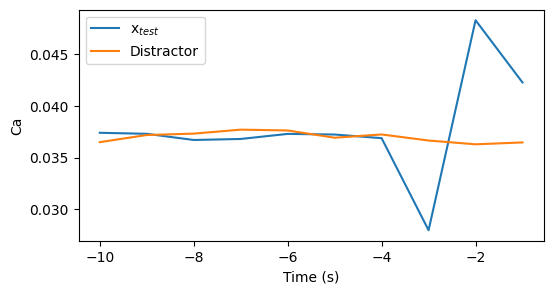

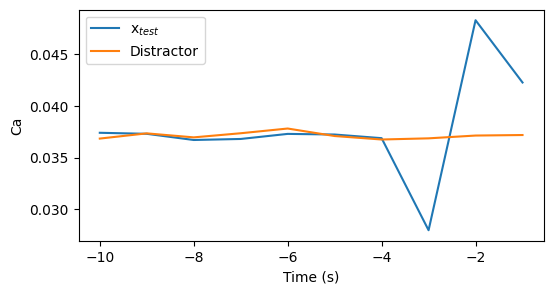

In [16]:
warnings.filterwarnings("ignore")

x_test = test_timeseries.loc[['node_1_33'], :, :]
explanation = comte.explain(x_test,to_maximize=0,savefig=False) 
print('###########') 
print(explanation)
print('###########')

warnings.resetwarnings()

2024-03-12 13:40:58,041 INFO    Working on turning label from 1 to 0


2024-03-12 13:40:58,048 INFO    Min dist:8.327663346116621 Min dist node:node_101_10
2024-03-12 13:40:58,056 INFO    Min dist:3.0220646989763025 Min dist node:node_101_15
2024-03-12 13:40:58,086 INFO    Min dist:2.8999420061056624 Min dist node:node_103_12
2024-03-12 13:40:58,089 INFO    Min dist:2.3403376160679876 Min dist node:node_103_20
2024-03-12 13:40:58,182 INFO    Returning distractors ['node_103_20']


###########
['Ca']
###########


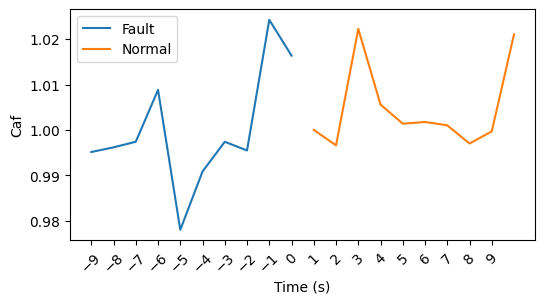

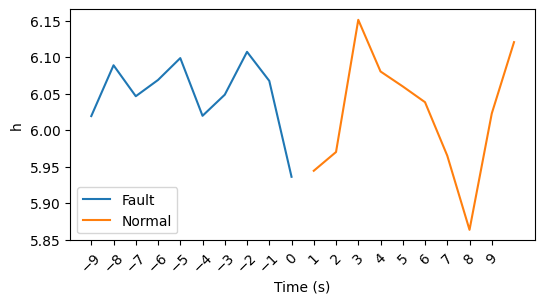

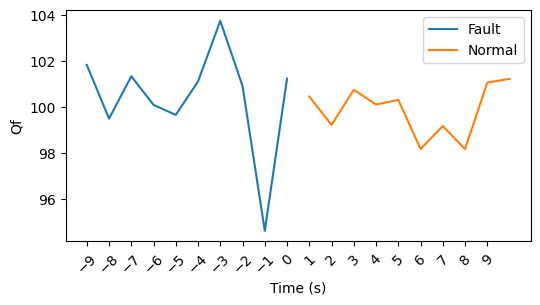

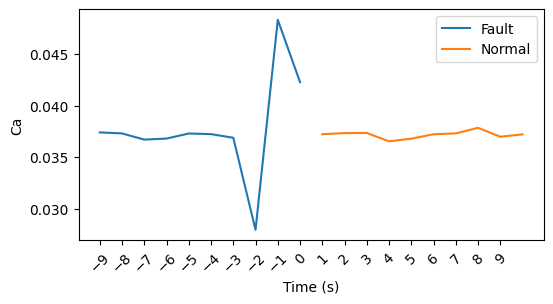

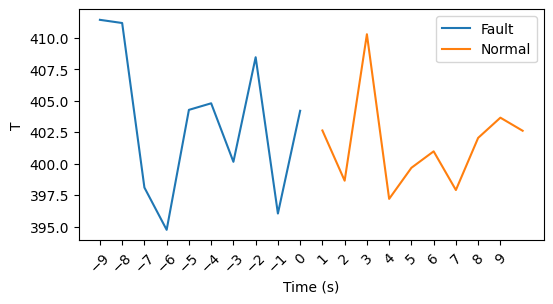

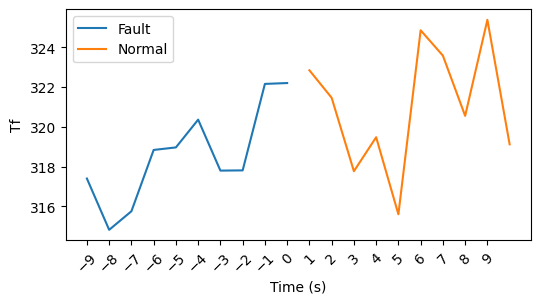

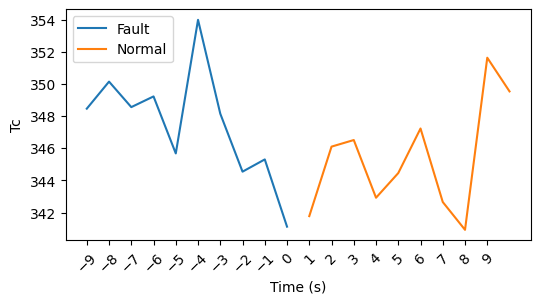

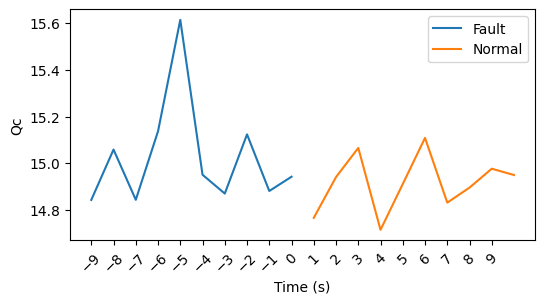

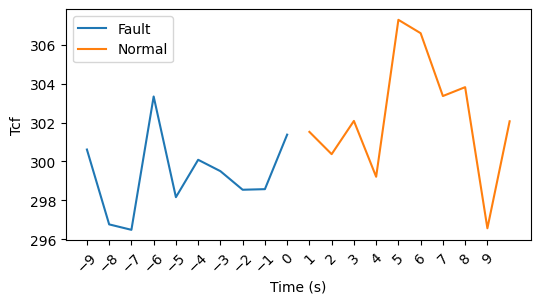

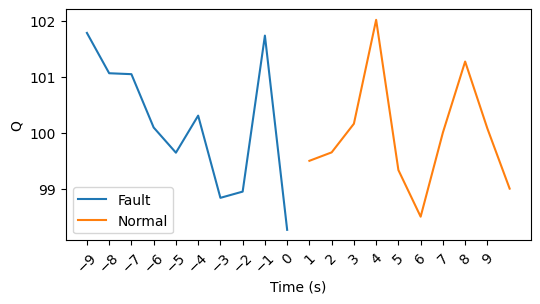

In [17]:
warnings.filterwarnings("ignore")

x_test = test_timeseries.loc[['node_1_33'], :, :]
proto_ts, proto_labels = comte.get_prototype(x_test,to_maximize=0,savefig=False) 
print('###########') 
print(explanation)
print('###########')

warnings.resetwarnings()

In [18]:
proto_preds = pipeline.predict(proto_ts)
# proto_preds
# proto_ts
# # 3 9 15

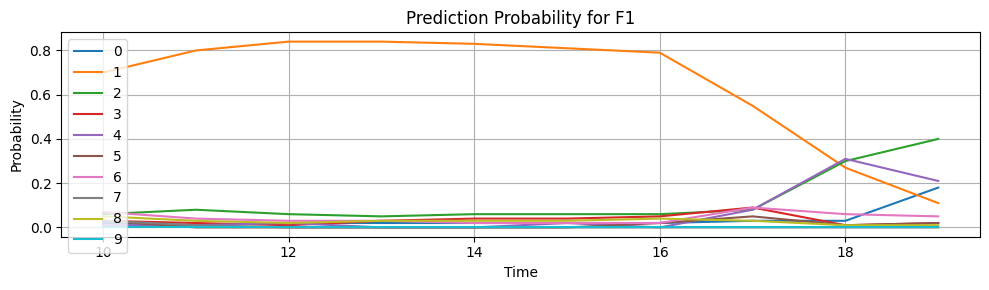

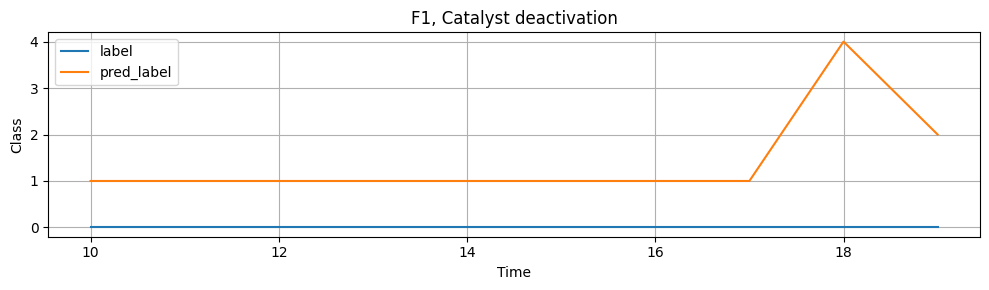

In [19]:
comparison_df=pd.DataFrame(proto_labels)
comparison_df['pred_label'] = proto_preds
comparison_df['ind_node'] = ([int(element.split('_')[1]) for element in comparison_df.index.get_level_values('node_id')])
comparison_df['ind_time'] = ([int(element.split('_')[2]) for element in comparison_df.index.get_level_values('node_id')])
comparison_df.set_index(['ind_node', 'ind_time'], inplace=True)
label_dict = {'1': 'F1, Catalyst deactivation', '2': 'F2, Heat-exchanger fouling', '3': 'F3, Dead-coolant flow measurement', '4': 'F4, Bias in reactor temperature measurement', '5': 'F5, Coolant valve stiction qF7', '6': 'F6, Step change in QF', '7': 'F7, Ramp change in CAF', '8': 'F8, Ramp change in TF', '9': 'F9, Ramp change in TCF', '0': 'N, Normal operation'}

warnings.filterwarnings("ignore")

for i in range(1,2):
    # print(comparison_df)
    single_node_df = comparison_df.loc[comparison_df.index.get_level_values('ind_node') == i]
    single_node_df = single_node_df.reset_index(level='ind_node', drop=True)
    single_node_df = single_node_df.sort_index()

    # print(single_node_df)
    # plt.figure(figsize=(20, 2))


# Plot prediction probability
    pred_ar = []
    for j in range(WINDOW_SIZE,20):
        loca = "node_{}_{}".format(i,j)
        predi = pipeline.predict_proba(proto_ts.loc[[loca], :, :])
        pred_ar.append(predi[0])
    pred_df = pd.DataFrame(pred_ar, index=range(WINDOW_SIZE,20))
    # print(pred_df)

    pred_df.plot(figsize=(10, 3))
    plt.title("Prediction Probability for F{}".format(i))
    plt.xlabel('Time')
    plt.ylabel('Probability')
    plt.grid(True)
    plt.legend(loc='upper left')
    # plt.yticks(np.arange(0, 1.1, step=0.1))
    # plt.xticks(np.arange(WINDOW_SIZE, len(single_node_df), step=1), rotation=45)
    # plt.xlim(single_node_df.index[5], single_node_df.index[45])
    plt.tight_layout()
    plt.show()


    single_node_df.plot(figsize=(10, 3))

    plt.title(label_dict[str(i)])
    plt.xlabel('Time')
    plt.ylabel('Class')
    plt.grid(True)
    plt.legend(loc='upper left')
    # plt.yticks(np.arange(0, 10, step=1))
    # plt.xticks(np.arange(WINDOW_SIZE, len(single_node_df), step=1), rotation=45)
    # plt.xlim(single_node_df.index[5], single_node_df.index[45])
    plt.tight_layout()
    plt.show()

warnings.resetwarnings()


In [20]:
# proto_ts.loc[['node_1_10'], :, :]
# # pipeline.predict_proba(proto_ts.loc[['node_1_10'], :, :])
# test_timeseries.loc[['node_1_33'], :, :]
# timeseries.loc[['node_101_30'], :, :]

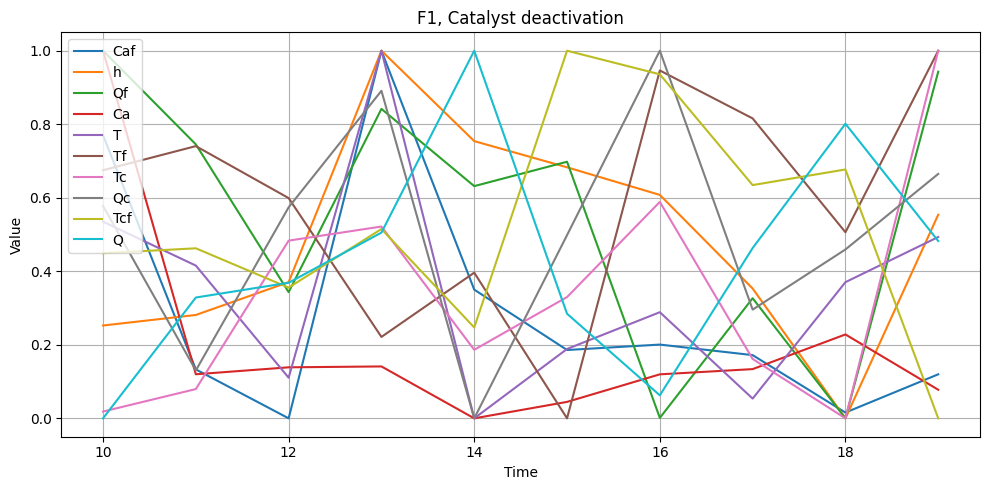

In [21]:
comparison_df=pd.DataFrame(proto_ts)
comparison_df = comparison_df.groupby(level='node_id').last()
comparison_df['ind_node'] = ([int(element.split('_')[1]) for element in comparison_df.index.get_level_values('node_id')])
comparison_df['ind_time'] = ([int(element.split('_')[2]) for element in comparison_df.index.get_level_values('node_id')])
comparison_df.set_index(['ind_node', 'ind_time'], inplace=True)
label_dict = {'1': 'F1, Catalyst deactivation', '2': 'F2, Heat-exchanger fouling', '3': 'F3, Dead-coolant flow measurement', '4': 'F4, Bias in reactor temperature measurement', '5': 'F5, Coolant valve stiction qF7', '6': 'F6, Step change in QF', '7': 'F7, Ramp change in CAF', '8': 'F8, Ramp change in TF', '9': 'F9, Ramp change in TCF', '0': 'N, Normal operation'}

for i in range(1,2):
    single_node_df = comparison_df.loc[comparison_df.index.get_level_values('ind_node') == i]
    single_node_df = single_node_df.reset_index(level='ind_node', drop=True)
    single_node_df = single_node_df.sort_index()
    
    single_node_df_filtered = single_node_df

    # columns_to_plot = ['Ca']
    # single_node_df_filtered = single_node_df[columns_to_plot]    

    scaler = MinMaxScaler()
    single_node_df_filtered = pd.DataFrame(scaler.fit_transform(single_node_df_filtered), columns=single_node_df_filtered.columns, index=single_node_df_filtered.index)    
    
    # print(single_node_df_filtered)

    single_node_df_filtered.plot(figsize=(10, 5))
    
    plt.title(label_dict[str(i)])
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid(True)
    plt.legend(loc='upper left')
    # plt.ticklabel_format(style='sci', axis='y', scilimits=(100,200))
    # plt.yticks(np.arange(0, 500, step=10))
    # plt.xticks(np.arange(WINDOW_SIZE, len(single_node_df_filtered), step=1), rotation=45)
    # plt.xlim(single_node_df_filtered.index[5], single_node_df_filtered.index[45])
    plt.tight_layout()
    plt.show()
